In [4]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

## Donwload the data

In [5]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

## Explore the data

In [6]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

## Build the model

In [7]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

In [29]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_6 (Dense)             (None, 16)                816       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [31]:
# Fit the model
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 114s 2s/step - loss: 0.6295 - accuracy: 0.7153 - val_loss: 0.5465 - val_accuracy: 0.8124
Epoch 2/10
30/30 [==============================] - 42s 1s/step - loss: 0.3732 - accuracy: 0.9438 - val_loss: 0.3797 - val_accuracy: 0.8549
Epoch 3/10
30/30 [==============================] - 40s 1s/step - loss: 0.2038 - accuracy: 0.9728 - val_loss: 0.3224 - val_accuracy: 0.8656
Epoch 4/10
30/30 [==============================] - 42s 1s/step - loss: 0.1305 - accuracy: 0.9831 - val_loss: 0.3073 - val_accuracy: 0.8710
Epoch 5/10
30/30 [==============================] - 42s 1s/step - loss: 0.0918 - accuracy: 0.9888 - val_loss: 0.3050 - val_accuracy: 0.8719
Epoch 6/10
30/30 [==============================] - 41s 1s/step - loss: 0.0674 - accuracy: 0.9933 - val_loss: 0.3101 - val_accuracy: 0.8713
Epoch 7/10
30/30 [==============================] - 42s 1s/step - loss: 0.0505 - accuracy: 0.9959 - val_loss: 0.3173 - val_accuracy: 0.8710
Epoch 8/10
30/30 [=

## Evaluate the model

In [32]:
results = model.evaluate(test_data.batch(512),verbose=2)

for name,value in zip(model.metrics_names,results):
  print("%s: %.3f" % (name,value))

49/49 - 9s - loss: 0.3771 - accuracy: 0.8550 - 9s/epoch - 189ms/step
loss: 0.377
accuracy: 0.855


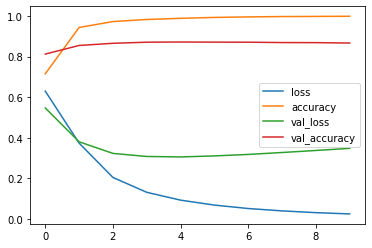

In [33]:
import pandas as pd
pd.DataFrame(history.history).plot();

In [34]:
predictions = model.predict(validation_data.batch(512))

20/20 [==============================] - 4s 183ms/step


In [35]:
predictions[:3]

array([[0.93875957],
       [0.9634626 ],
       [0.99373746]], dtype=float32)

In [62]:
pred_labels = list(tf.squeeze(tf.round(predictions)).numpy())

In [74]:
target_df = pd.DataFrame(data = pred_labels,
                  columns =[ 'Target'])

In [75]:
target_df['Target'].value_counts()

1.0    5008
0.0    4992
Name: Target, dtype: int64

In [78]:
model.predict(['I hate this movie horrible'])

1/1 [==============================] - 0s 461ms/step


array([[0.0569297]], dtype=float32)